In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print(f"{table_name}:{column.get('name')} , {column.get('type')}")

measurement:id , INTEGER
measurement:station , TEXT
measurement:date , TEXT
measurement:prcp , FLOAT
measurement:tobs , FLOAT
station:id , INTEGER
station:station , TEXT
station:name , TEXT
station:latitude , FLOAT
station:longitude , FLOAT
station:elevation , FLOAT


# Exploratory Climate Analysis

In [11]:
# Calculate the date 1 year ago from the last data point in the database
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

one_year_from_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=366)
one_year_from_date

datetime.datetime(2016, 8, 22, 0, 0)

In [12]:
# Perform a query to retrieve the data and precipitation scores
date_precip_scores = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date >= one_year_from_date)\
.group_by(Measurement.date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_precip_df = pd.DataFrame(date_precip_scores,columns=['date', 'precipitation'])
date_precip_df['date'] = pd.to_datetime(date_precip_df['date'], format='%Y-%m-%d')
date_precip_df.sort_values(by="date", ascending=True)
date_precip_df.set_index("date", inplace=True)
date_precip_df.dropna(inplace=True)
date_precip_df

,precipitation
date,
2016-08-23,0.70
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-28,2.07
2016-08-29,0.90
2016-08-30,0.05
2016-08-31,2.46
2016-09-01,0.01


In [14]:
one_year_from_date = one_year_from_date.date()
one_year_from_date

datetime.date(2016, 8, 22)

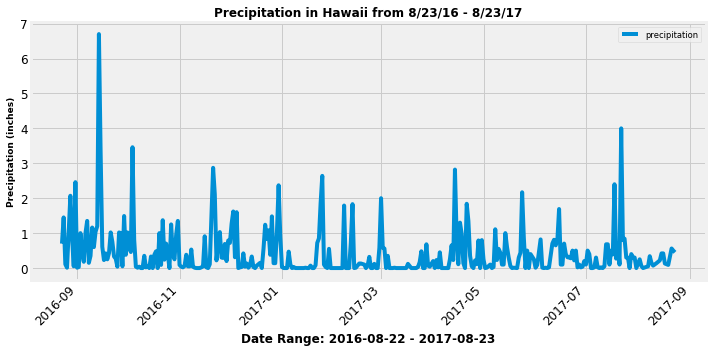

In [15]:
date_precip_df.plot(use_index=True, y='precipitation', figsize=(10,5))
plt.title("Precipitation in Hawaii from 8/23/16 - 8/23/17", fontweight='bold',size=12)
plt.xlabel(f"Date Range: {one_year_from_date} - {most_recent_date}", fontweight='bold', size=12)
plt.ylabel("Precipitation (inches)", fontweight='bold', size=9)
plt.yticks(size=12)
plt.xticks(rotation=45, size=12)
plt.legend(["precipitation"],loc="best", fontsize="small")
plt.tight_layout()

plt.savefig("Images/Precipitation_Hawaii.png")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_precip_df.describe()

,precipitation
count,345.000000
mean,0.432087
std,0.704363
min,0.000000
25%,0.010000
50%,0.140000
75%,0.580000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Station.id,Station.station,Station.name)
print(f"There are {available_stations.count()} available stations.")

There are 9 available stations.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_sorted = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc())
for each_station in stations_sorted:
    print(each_station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [19]:
# Which station has the highest number of observations?
most_active_station = stations_sorted[0][0]
most_active_station_observations = stations_sorted[0][1]
print(f"The most active station is {most_active_station} with {most_active_station_observations} observations.")

The most active station is USC00519281 with 2772 observations.


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
recorded_most_active = session.query(Station.name, func.min(Measurement.tobs),
                                    func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                                    .filter(Measurement.station == most_active_station).all()
print(f"The most active station, {most_active_station}, recorded the lowest temperature of {recorded_most_active[0][1]},\
 the highest temperature of {recorded_most_active[0][2]}, and the average temperature of {round(recorded_most_active[0][3], 1)}.")

The most active station, USC00519281, recorded the lowest temperature of 54.0, the highest temperature of 85.0, and the average temperature of 71.7.


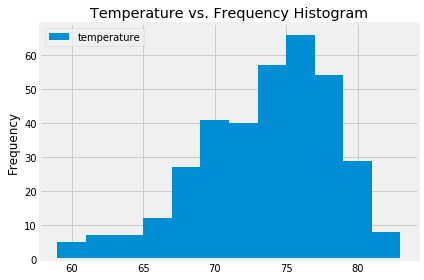

In [21]:
# Choose the station with the highest number of temperature observations.
stations_query = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_tobs_station= stations_query[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).filter(Measurement.date >= one_year_from_date).filter(Measurement.station == most_tobs_station).all()
tobs_df = pd.DataFrame(tobs_data, columns=["temperature"])

tobs_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()
plt.savefig("Images/Temperature_Frequency.png")
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-08-12','2016-08-20')
trip_temps

[(71.0, 78.08620689655173, 83.0)]

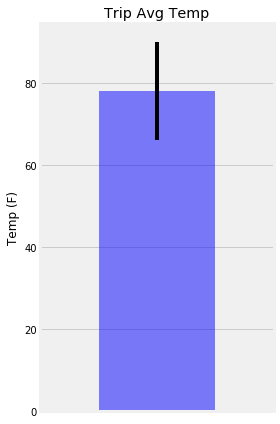

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temps_df = pd.DataFrame(trip_temps, columns = ["tmin", "tavg", "tmax"])
trip_temps_df.head()

trip_temps_df.plot.bar(y='tavg', yerr=(trip_temps_df['tmax'] - trip_temps_df['tmin']), title='Trip Avg Temp', color='blue', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/Trip_Avg_Temp.png")
plt.show()